In [1]:
import os 
import json
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

from nebula.evaluation import readCrossValidationFolder, readCrossValidationMetricFile
from nebula.plots import (
    plotCounterCountsLineplot, plotCrossValidationFolder,
    plotCrossValidationFieldvsKeys, plotVocabSizeMaxLenTests,
    plotCrossValidationDict, plotCrossValidationTrainingTime,
    plotVocabSizeMaxLenArchComparison, plotVocabSizeMaxLenHeatmap
)

PLOT_OUT_FOLDER = r"evaluation\_crossValidationPlots"
os.makedirs(PLOT_OUT_FOLDER, exist_ok=True)

inRootFolder = r"evaluation\crossValidation"

# Comparison of the preprocessing methods

All the preprocessing methods were compared using cross-validation over three folds, reporting mean and standard deviation of metrics across all folds.

The following preprocessing methods were compared:

1. API call names only
2. Extra added: Network, Registry, File manipulations (if any)
3. Extra added: API call arguments
4. Extra added: Speakeasy emulator error (if thrown at some point during emulation)
5. Extra added: Queries DNS domain names (if any)

## Vocabulary sizes

It is important to note that different preprocessing techniques yield different vocabulary sizes, for instance, below is vocabulary sizes for first three preprocessing methods:

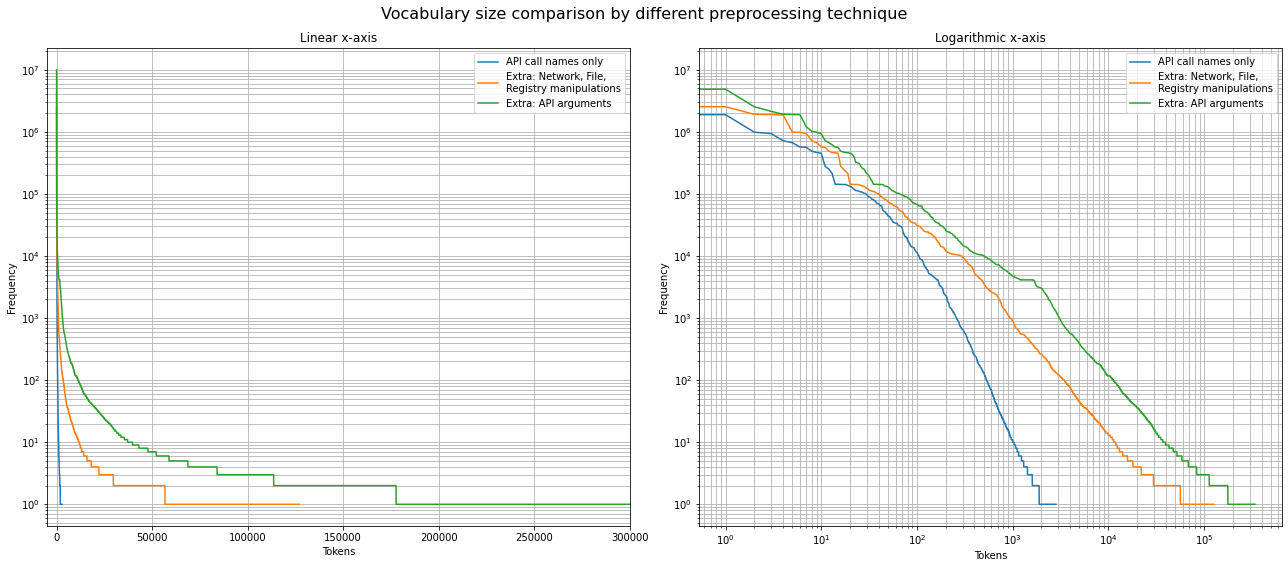

In [2]:
counterAPIonly = r"data\data_filtered\speakeasy_trainset_APIonly\speakeasy_counter.pkl"
counterAPI_Network_File_Reg = r"data\data_filtered\speakeasy_trainset_API_Network_File_Reg\speakeasy_counter.pkl"
counterAPIargs = r"data\data_filtered\speakeasy_trainset_WithAPIargs\speakeasy_counter.pkl"

with open(counterAPIonly, "rb") as f:
    counterAPIonly = pickle.load(f)
with open(counterAPIargs, "rb") as f:
    counterAPIargs = pickle.load(f)
with open(counterAPI_Network_File_Reg, "rb") as f:
    counterAPI_Network_File_Reg = pickle.load(f)

fig, axs = plt.subplots(1, 2, figsize=(18, 8))
[ax.plot(np.arange(len(counterAPIonly)), [x[1] for x in counterAPIonly.most_common()]) for ax in axs]
[ax.plot(np.arange(len(counterAPI_Network_File_Reg)), [x[1] for x in counterAPI_Network_File_Reg.most_common()]) for ax in axs]
[ax.plot(np.arange(len(counterAPIargs)), [x[1] for x in counterAPIargs.most_common()]) for ax in axs]
[ax.set_xlabel("Tokens") for ax in axs]
[ax.set_ylabel("Frequency") for ax in axs]
[ax.grid(which="both") for ax in axs]
[ax.set_yscale("log") for ax in axs]
axs[1].set_xscale("log")
axs[0].set_xlim(-5000, 3e5)
[ax.legend(["API call names only", "Extra: Network, File,\nRegistry manipulations", "Extra: API arguments", ]) for ax in axs]
axs[0].set_title("Linear x-axis")
axs[1].set_title("Logarithmic x-axis")
_ = fig.suptitle("Vocabulary size comparison by different preprocessing technique", fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(PLOT_OUT_FOLDER, "_vocabularySizeComparison.png"), dpi=300)

## Performance lineplots with `maxLen=1024` and `vocabSize=2000` under fixed False-Positive Rates (FPR)


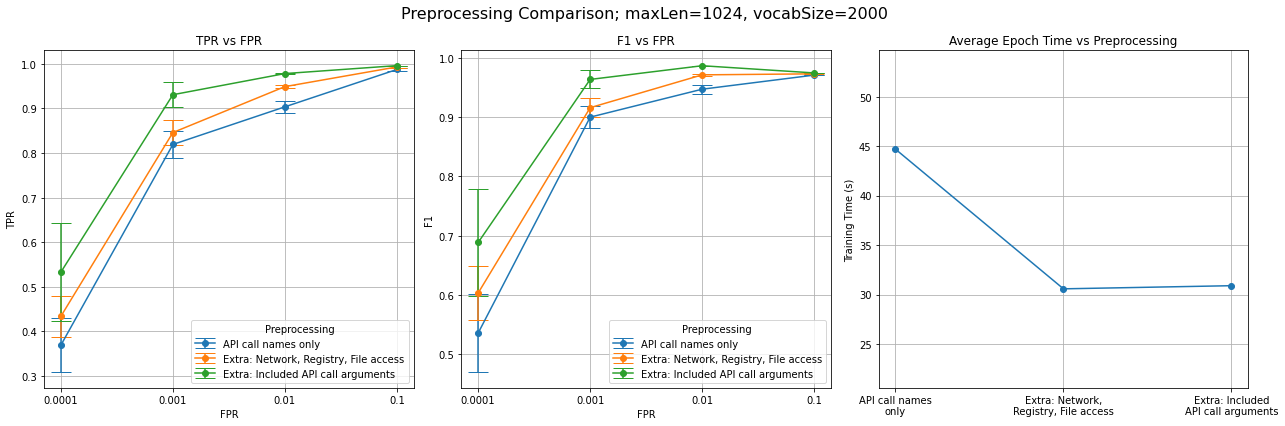

In [2]:
figSize = (18, 6)
title="Preprocessing"
labels = [
    "API call names only", 
    "Extra: Network, Registry, File access",
    "Extra: Included API call arguments",
]
labelsXticks = [
    "API call names\nonly", 
    "Extra: Network,\nRegistry, File access",
    "Extra: Included\nAPI call arguments",
]

inFolders = [
    rf"{inRootFolder}\APIonly\Cnn1DLinear_VocabSize_maxLen",
    rf"{inRootFolder}\API_Network_File_Reg\Cnn1DLinear_VocabSize_maxLen",
    rf"{inRootFolder}\WithAPIargs\Cnn1DLinear_VocabSize_maxLen",
]
vocabSize = 2000
maxLen = 1024
_, _, fig, ax = plotVocabSizeMaxLenArchComparison(inFolders, maxLen=maxLen, vocabSize=vocabSize, savePath=None, legendTitle=title, title=title, legendValues=[labels, labelsXticks])

plt.tight_layout()
savePath = f"{PLOT_OUT_FOLDER}/_PreProcessingComparison.png"
plt.savefig(savePath)

> NOTE: This might not be fully objective, since large vocab method with API call `args` benefit from larger vocabularies (as shown on heatmaps below), but other pre-processing methods (i.e. without API call arguments) are better tuned to `vocabSize=2000`. Therefore, real benefit of API call argument preprocessing might be even more superior than shown here.

As mentioned above, extra additional information was considered:

4. Speakeasy emulator error (if thrown at some point during emulation);
5. Queries DNS domain names (if any);

Both yielded **degraded** performance as shown below, similar to the results of API call names only.

> NOTE: DNS query information might be analyzed by a separate model that does 1D-CNN over characters?

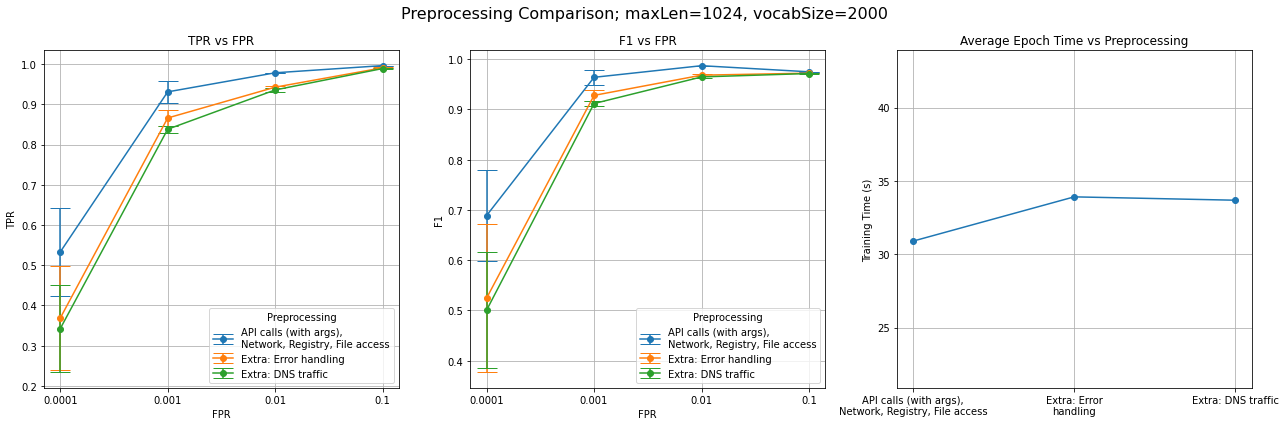

In [6]:
inFoldersNew = [
    rf"{inRootFolder}\WithAPIargs\Cnn1DLinear_VocabSize_maxLen",
    rf"{inRootFolder}\WithError\Cnn1DLinear_VocabSize_maxLen",
    rf"{inRootFolder}\WithDns\Cnn1DLinear_VocabSize_maxLen",
]
figSize = (18, 6)
title="Preprocessing"
labelsNew = [
    "API calls (with args),\nNetwork, Registry, File access",
    "Extra: Error handling",
    "Extra: DNS traffic",
]
labelsXticksNew = [
    "API calls (with args),\nNetwork, Registry, File access",
    "Extra: Error\nhandling",
    "Extra: DNS traffic",
]
vocabSize = 2000
maxLen = 1024
_, _, fig, ax = plotVocabSizeMaxLenArchComparison(inFoldersNew, maxLen=maxLen, vocabSize=vocabSize, savePath=None, legendTitle=title, title=title, legendValues=[labelsNew, labelsXticksNew])

plt.tight_layout()
savePath = f"{PLOT_OUT_FOLDER}/_PreProcessingComparison_withErrDns.png"
plt.savefig(savePath)

# API args full heatmap

The most successful preprocessing method was extensively evaluated with different `maxLen` and `vocabSize` parameters. The following heatmap shows the True-Positive Rate (TPR) and F1-score under FPR=0.0001 (detection rates with one false alert in 1000 evaluations) of with different `maxLen` and `vocabSize` parameters.

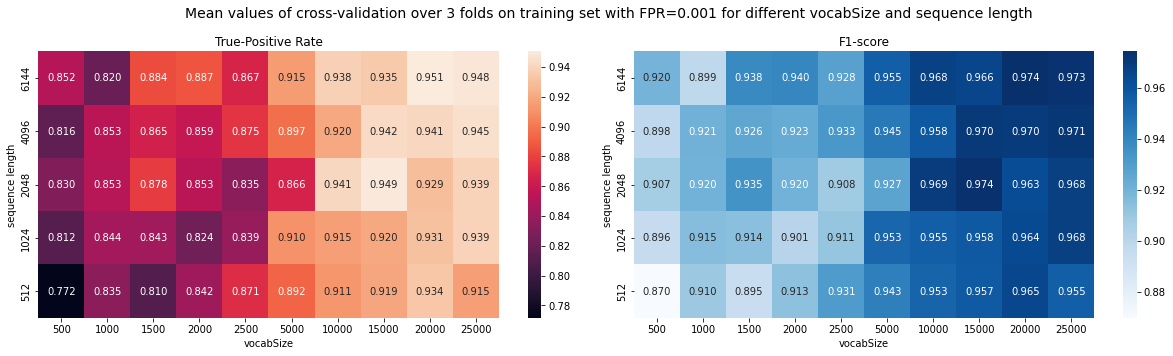

In [5]:
fpr = "0.001"
inFolder = rf"{inRootFolder}\WithAPIargs\Cnn1DLinear_VocabSize_maxLen"
savePath = f"{PLOT_OUT_FOLDER}/_fullVocabSizeMaxLenHeatmap_fpr_0_001.png"
_ = plotVocabSizeMaxLenHeatmap(inFolder, fpr, savePath=savePath, rangeL=None, figSize=(17,5),
                            supTitle="Mean values of cross-validation over 3 folds on training set")

The same, but with FPR=0.001 (detection rate with one false alert on 10 000 examinations).

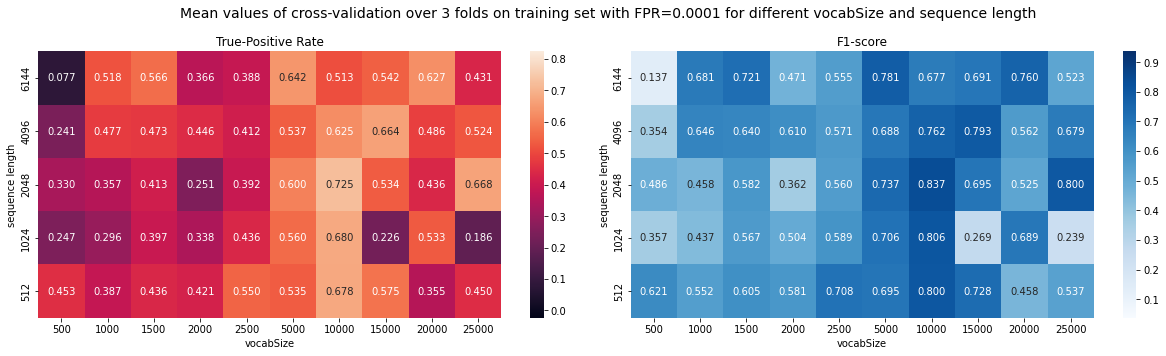

In [6]:
fpr = "0.0001"
inFolder = rf"{inRootFolder}\WithAPIargs\Cnn1DLinear_VocabSize_maxLen"
savePath = f"{PLOT_OUT_FOLDER}/_fullVocabSizeMaxLenHeatmap_fpr_0_0001.png"
_ = plotVocabSizeMaxLenHeatmap(inFolder, fpr, savePath=savePath, rangeL=0.1, figSize=(17,5),
                            supTitle="Mean values of cross-validation over 3 folds on training set")

#### TL;DR: While increasing vocab size, sequence length and model's complexity further might yield higher metrics, `vocabSizes` either `10000` or `15000`, and `maxLen=2048` express ability to be a good middle ground for further tests.

## Mini-heatmaps (smaller sizes of `vocabSize`) for various method comparison

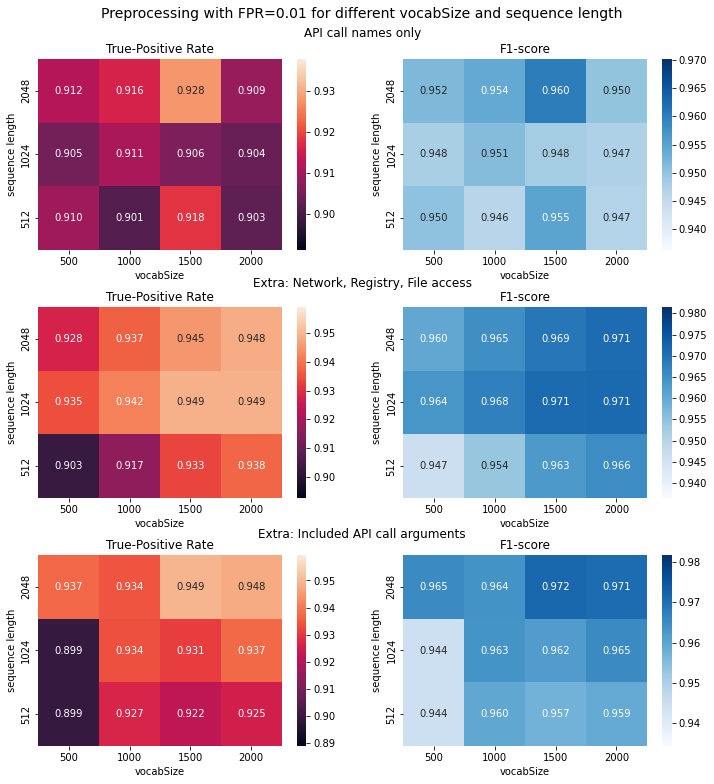

In [3]:
def plotHeatMapsInFolders(inFolders, fpr, vocabSizes, maxLengths, rangeL=0.01, subplotTitles=None, savePath=None):

    # create 6 plots 3 rows, 2 columns
    fig, axs = plt.subplots(3, 2, figsize=(12, 12))

    for i, inFolder in enumerate(inFolders):
        plotVocabSizeMaxLenHeatmap(inFolder, fpr,
                                    savePath=None,
                                    rangeL=rangeL,
                                    vocabSizes=vocabSizes, 
                                    maxLens=maxLengths,  
                                    axs=[axs[i,0], axs[i,1]]
                                )
    _ = plt.suptitle(f"Preprocessing with FPR={fpr} for different vocabSize and sequence length", fontsize=14)
    # increase gap between subplot rows
    plt.subplots_adjust(hspace=0.3)
    # reduce gap after suptitle
    plt.subplots_adjust(top=0.92)
    if subplotTitles:
        for height, subplotTitle in zip([0.95, 0.66, 0.37], subplotTitles):
            plt.figtext(0.5, height, subplotTitle, ha="center", va="center", fontsize=12)
    if savePath:
        plt.savefig(savePath)
    return fig, axs

vocabSizes = [500, 1000, 1500, 2000]
maxLengths = [512, 1024, 2048]
savePath=f"{PLOT_OUT_FOLDER}/PreProcessingComparisonHeatmap_FPR_0_01.png"
_ = plotHeatMapsInFolders(inFolders, "0.01", vocabSizes, maxLengths, savePath=savePath, subplotTitles=labels)

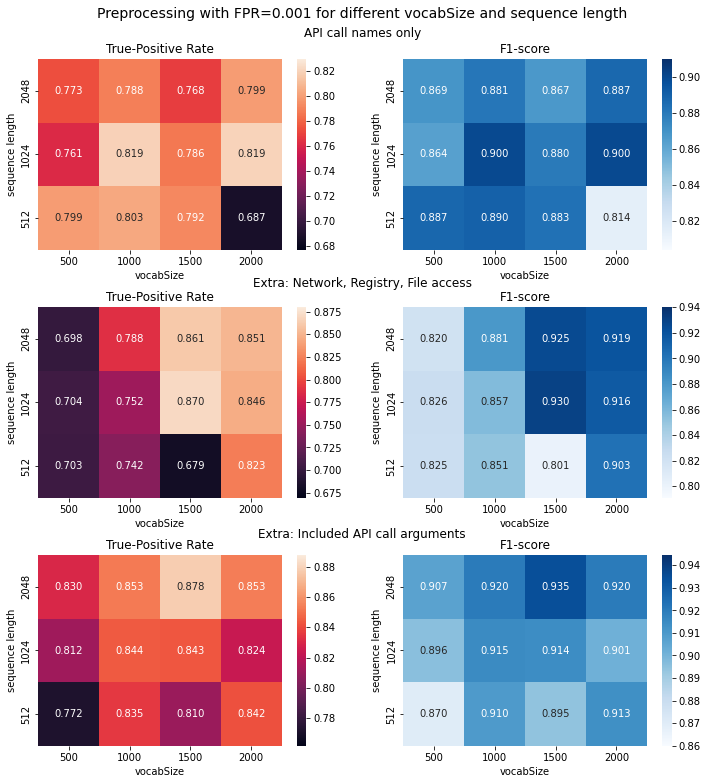

In [4]:
savePath=f"{PLOT_OUT_FOLDER}/PreProcessingComparisonHeatmap_FPR_0_001.png"
_ = plotHeatMapsInFolders(inFolders, "0.001", vocabSizes, maxLengths, savePath=savePath, subplotTitles=labels)

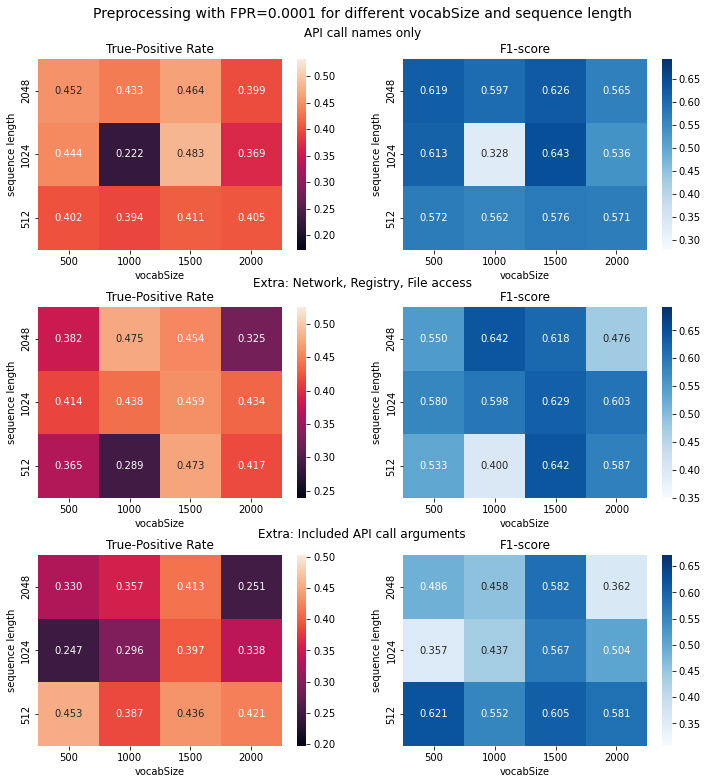

In [5]:
savePath=f"{PLOT_OUT_FOLDER}/PreProcessingComparisonHeatmap_FPR_0_0001.png"
_ = plotHeatMapsInFolders(inFolders, "0.0001", vocabSizes, maxLengths, rangeL=0.05, savePath=savePath, subplotTitles=labels)